# Mnist

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from tensorboardX import SummaryWriter
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import ImageStat
import matplotlib.pyplot as plt
import math
import time
import os

In [2]:
num_epochs = 5
learning_rate = 1e-4
batch_size = 100
model_save_dir = './models'
model_name = 'v1_lr_1e-4'
log_dir = './runs'

## Dataset

In [3]:
dataset_dir = './data'
dataset = torchvision.datasets.MNIST(dataset_dir, train=True, download=True)

mean = np.zeros(1)
for i in range(len(dataset)):
    image = dataset[i][0]
    stat = ImageStat.Stat(image)
    mean += np.array(stat.mean)
    print('\r{:.2f}%'.format(100*i/len(dataset)), end='\r')
mean /= len(dataset)*255
print(mean)

[ 0.13066048]


In [4]:
def show_tensor_image(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.13066048 for _ in range(3)])
    inp = inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

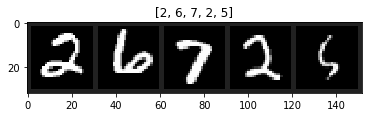

In [5]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, [1., 1., 1.])
])
dataset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=trans)
dataloader = DataLoader(dataset, batch_size=5, shuffle=True, num_workers=1)
images, labels = next(iter(dataloader))
show_tensor_image(torchvision.utils.make_grid(images), title=[x.item() for x in labels])

In [6]:
trans = {}
trans['train'] = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, [1., 1., 1.])
])
trans['test'] = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, [1., 1., 1.])
])
datasets = {
    'train': torchvision.datasets.MNIST(dataset_dir, train=True, download=True, transform=trans['train']),
    'test': torchvision.datasets.MNIST(dataset_dir, train=False, download=True, transform=trans['test'])
}
dataloaders = {x: DataLoader(datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
                for x in ['train', 'test']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'test']}
print(dataset_sizes)

{'train': 60000, 'test': 10000}


In [7]:
images, labels = next(iter(dataloaders['train']))
print(images.size())
print(labels.size())
print(images[0])
print(labels[0])

torch.Size([100, 1, 28, 28])
torch.Size([100])
tensor([[[-0.1307, -0.1307, -0.1307, -0.1307, -0.1307, -0.1307, -0.1307,
          -0.1307, -0.1307, -0.1307, -0.1307, -0.1307, -0.1307, -0.1307,
          -0.1307, -0.1307, -0.1307, -0.1307, -0.1307, -0.1307, -0.1307,
          -0.1307, -0.1307, -0.1307, -0.1307, -0.1307, -0.1307, -0.1307],
         [-0.1307, -0.1307, -0.1307, -0.1307, -0.1307, -0.1307, -0.1307,
          -0.1307, -0.1307, -0.1307, -0.1307, -0.1307, -0.1307, -0.1307,
          -0.1307, -0.1307, -0.1307, -0.1307, -0.1307, -0.1307, -0.1307,
          -0.1307, -0.1307, -0.1307, -0.1307, -0.1307, -0.1307, -0.1307],
         [-0.1307, -0.1307, -0.1307, -0.1307, -0.1307, -0.1307, -0.1307,
          -0.1307, -0.1307, -0.1307, -0.1307, -0.1307, -0.1307, -0.1307,
          -0.1307, -0.1307, -0.1307, -0.1307, -0.1307, -0.1307, -0.1307,
          -0.1307, -0.1307, -0.1307, -0.1307, -0.1307, -0.1307, -0.1307],
         [-0.1307, -0.1307, -0.1307, -0.1307, -0.1307, -0.1307, -0.1307,
 

## Model

In [8]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.features = nn.Sequential(
            #28x28
            nn.Conv2d(1, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            #14x14
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            #7x7
        )

        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 10)
        )
        
        self._initialize_weights()
        

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

## Training

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
writer = {x: SummaryWriter(log_dir=os.path.join(log_dir, model_name, x),
                comment=model_name)
          for x in ['train', 'test']}

In [10]:
model = Model().to(device)
criterion = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,30], gamma=0.1)

In [11]:
def training():
    since = time.time()
    best_model_wts = model.state_dict()
    best_accuracy = 0.0
    iter_num = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        #scheduler.step()
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for idx, data in enumerate(dataloaders[phase]):
                # get the inputs
                inputs, labels = data

                inputs = inputs.to(device)
                labels = labels.to(device)
                
                if phase == 'train':
                    torch.set_grad_enabled(True)
                else:
                    torch.set_grad_enabled(False)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    iter_num += 1

                # statistics
                running_loss += loss.item()
                _, preds = torch.max(outputs.detach(), 1)
                running_corrects += torch.sum(preds == labels.detach()).item()

                if idx%10 == 0:
                    if phase == 'train':
                        preds = preds.to('cpu')
                        labels = labels.detach().to('cpu')
                        writer[phase].add_scalar('loss', loss.item()/len(preds), iter_num)
                        writer[phase].add_scalar('accuracy', accuracy_score(preds.numpy(), labels.numpy()), iter_num)
                    print('\r{} {:.2f}%'.format(phase, 100*idx/len(dataloaders[phase])), end='\r')

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_accuracy = running_corrects / dataset_sizes[phase]

            if phase == 'test':
                writer[phase].add_scalar('loss', epoch_loss, iter_num)
                writer[phase].add_scalar('accuracy', epoch_accuracy, iter_num)
            print('{} Loss: {:.4f} Accuracy: {:.4f}'.format(
                phase, epoch_loss, epoch_accuracy))

            # save model
            if phase == 'test' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_wts = model.state_dict()
                model_dir = os.path.join(model_save_dir, model_name+'.pth')
                if not os.path.exists(model_save_dir):
                    os.makedirs(model_save_dir)
                torch.save(model.state_dict(), model_dir)
                print('Model saved to %s'%(model_dir))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Test Accuracy: {:4f}'.format(best_accuracy))

    # load best model weights
    model.load_state_dict(best_model_wts)

In [12]:
training()

Epoch 0/4
----------
train Loss: 0.3700 Accuracy: 0.8798
test Loss: 0.0597 Accuracy: 0.9793
Model saved to ./models/v1_lr_1e-4.pth

Epoch 1/4
----------
train Loss: 0.0762 Accuracy: 0.9777
test Loss: 0.0332 Accuracy: 0.9889
Model saved to ./models/v1_lr_1e-4.pth

Epoch 2/4
----------
train Loss: 0.0588 Accuracy: 0.9818
test Loss: 0.0346 Accuracy: 0.9895
Model saved to ./models/v1_lr_1e-4.pth

Epoch 3/4
----------
train Loss: 0.0467 Accuracy: 0.9861
test Loss: 0.0254 Accuracy: 0.9907
Model saved to ./models/v1_lr_1e-4.pth

Epoch 4/4
----------
train Loss: 0.0415 Accuracy: 0.9875
test Loss: 0.0319 Accuracy: 0.9905

Training complete in 0m 38s
Best Test Accuracy: 0.990700
